# Multi-task

In [ ]:
import os 
import time
import glob
import pandas as pd
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.metrics import confusion_matrix

In [ ]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# 請輸入資料夾之所在位置
FOLDERNAME = 'Colab\ Notebooks/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


## Stats

In [ ]:
df = pd.read_csv("video_data_info_3.csv", index_col=0)
df

,path,filename,new_filename,subset,safe_to_walk,roadway_width,crosswalk,crosswalk_signal,traffic_light,car,scooter,bike,other_obstacles,no_obstacle_in_crosswalk,weather
0,V_pic_3/3_0001.png,3_0001.png,3_0001.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V_pic_3/3_0002.png,3_0002.png,3_0002.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V_pic_3/3_0003.png,3_0003.png,3_0003.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V_pic_3/3_0004.png,3_0004.png,3_0004.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V_pic_3/3_0005.png,3_0005.png,3_0005.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,V_pic_3/3_0100.png,3_0100.png,3_0100.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,V_pic_3/3_0101.png,3_0101.png,3_0101.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,V_pic_3/3_0102.png,3_0102.png,3_0102.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,V_pic_3/3_0103.png,3_0103.png,3_0103.jpg,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.query("subset == 'train'").describe()

,safe_to_walk,roadway_width,crosswalk,crosswalk_signal,traffic_light,car,scooter,bike,other_obstacles,no_obstacle_in_crosswalk,weather
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


Series([], Name: roadway_width, dtype: int64)

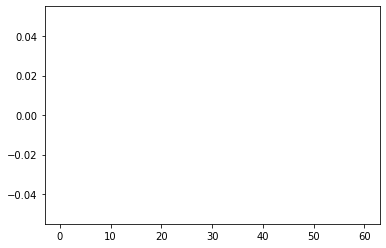

In [ ]:
fig = plt.figure()
plt.hist(df["roadway_width"], np.linspace(0, 60, 13))  # numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
df["roadway_width"].value_counts()

In [ ]:
df["roadway_width_cat"] = np.clip(np.floor(df["roadway_width"] / 5.0), 0, 7)
df["roadway_width_cat"] = df["roadway_width_cat"].apply(int)
df["roadway_width_cat"].value_counts()
fig = plt.figure()
plt.hist(df["roadway_width_cat"], np.linspace(0, 8, 9))

ValueError: ignored

In [ ]:
fig = plt.figure()
plt.hist(df["crosswalk"], np.linspace(0, 1, 20))
df["crosswalk"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["crosswalk_signal"], np.linspace(0, 3, 4))
df["crosswalk_signal"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["traffic_light"], np.linspace(0, 3, 4))
df["traffic_light"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["car"], np.linspace(0, 2, 3))
df["car"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["scooter"], np.linspace(0, 2, 3))
df["scooter"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["bike"], np.linspace(0, 2, 3))
df["bike"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["other_obstacles"], np.linspace(0, 2, 3))
df["other_obstacles"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["no_obstacle_in_crosswalk"], np.linspace(0, 2, 3))
df["no_obstacle_in_crosswalk"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["weather"], np.linspace(0, 3, 4))
df["weather"].value_counts()

In [ ]:
roadway_width_cat_weight = 100.0 / df["roadway_width_cat"].value_counts().sort_index()
roadway_width_cat_weight = roadway_width_cat_weight / np.min(roadway_width_cat_weight)
roadway_width_cat_weight

In [ ]:
crosswalk_signal_cat_weight = 1.0 / df["crosswalk_signal"].value_counts().sort_index()
crosswalk_signal_cat_weight = crosswalk_signal_cat_weight / np.min(crosswalk_signal_cat_weight)
crosswalk_signal_cat_weight

In [ ]:
traffic_light_cat_weight = 1.0 / df["traffic_light"].value_counts().sort_index()
traffic_light_cat_weight = traffic_light_cat_weight / np.min(traffic_light_cat_weight)
traffic_light_cat_weight

In [ ]:
weather_cat_weight = 1.0 / df["weather"].value_counts().sort_index()
weather_cat_weight = weather_cat_weight / np.min(weather_cat_weight)
weather_cat_weight

## Dataset+transforms

In [ ]:
class PedXingDataset(Dataset):
    
    def __init__(self, df_path, data_dir, subset, n=-1, dist_bin_size=5.0, verbose=False):
        self.df = pd.read_csv(df_path, index_col=0).query("subset == '{}'".format(subset))
        if n > 0:
            self.df = self.df.sample(n)
        self.n = len(self.df)
        self.dist_bin_size = dist_bin_size
        self.data_dir = data_dir
        self.verbose = verbose
        if subset == "train":
          self.transforms = transforms.Compose([
              transforms.ToTensor(),  # 0-255 => 0.0 - 1.0
              # transforms.RandomInvert(p=0.7),
              transforms.RandomAffine(
                  degrees=3,
                  translate=(0.1, 0.1),
                  scale=(1.0, 1.2),
              ),
              transforms.Normalize((0.485, 0.456, 0.406),
                                    (0.229, 0.224, 0.225)),
          ])
        else:
            self.transforms = transforms.Compose([
              transforms.ToTensor(), # 0-255 => 0.0 - 1.0
              transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        y = torch.Tensor(
        #     self.df.iloc[idx][["safe_to_walk", "roadway_width", "weather", "car", "scooter", "bike"]]
        # ).long()
            self.df.iloc[idx][["safe_to_walk", "roadway_width", "crosswalk", "crosswalk_signal", "traffic_light", 
                               "car", "scooter", "bike", "other_obstacles", "no_obstacle_in_crosswalk", "weather"]]).long()
        y[1] = torch.clamp(y[1] / self.dist_bin_size, 0, 7) # eqv. np.clip()
        x = Image.open(os.path.join(self.data_dir, self.df.iloc[idx]["new_filename"]))
        x = self.transforms(x)
        return x, y
    
train_ds = PedXingDataset("data_info_v4.csv", data_dir="processed_data", subset="train", verbose=False)
val_ds = PedXingDataset("data_info_v4.csv", data_dir="processed_data", subset="val", verbose=False)
test_ds = PedXingDataset("video_data_info_3.csv", data_dir="processed_data_3", subset="test", verbose=False)

In [ ]:
x, y = train_ds[0]
x.size()

torch.Size([3, 1024, 1024])

In [ ]:
y

tensor([1, 6, 1, 2, 2, 0, 0, 1, 0, 1, 0])

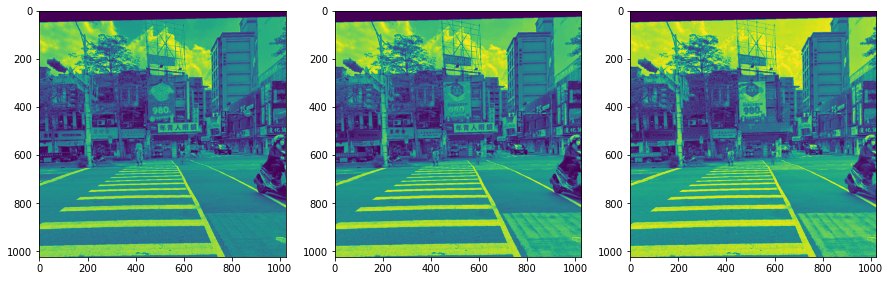

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 5)
plt.subplot(1, 3, 1)
plt.imshow(x[0, :, :])
plt.subplot(1, 3, 2)
plt.imshow(x[1, :, :])
plt.subplot(1, 3, 3)
plt.imshow(x[2, :, :])

## DataLoader

In [ ]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=9)
train_dl

In [ ]:
val_dl = DataLoader(val_ds, shuffle=False, batch_size=9)
val_dl

In [ ]:
test_dl = DataLoader(test_ds, shuffle=False, batch_size=9)
test_dl

## Multi-task learning
- safe_to_walk: binary. 0, 1
- roadway_width: cat. 0, 1, 2, 3, 4, 5, 6, 7
- crosswalk: binary. 0, 1
- crosswalk_signal: cat. 0, 1, 2
- traffic_light: cat. 0, 1, 2
- car: binary. 0, 1
- scooter: binary. 0, 1
- bike: binary. 0, 1
- other_obstacles: binary. 0, 1
- no_obstacle_in_crosswalk: binary. 0, 1
- weather: cat. 0, 1, 2

### Hyperparameters
- Choice of model (architecture)
- numbers of hidden layers
- numbers of  hidden layer filters
- Choice of optimizer
- learning rate (aka lr)

### Pre-trained model

In [ ]:
pre_model = models.vgg16(pretrained=True)
pre_model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Hidden layers

In [ ]:
n_hidden = 256
n_layers = 3  # functional n > 2

my_block = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.ReLU(),
)

my_hidden = nn.Sequential(
    *[my_block for i in range(n_layers - 2)]
)

my_hidden

Sequential(
  (0): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
)

In [ ]:
n_features = 25088  # num of in_features in fc layer of pre-trained model
n_out = 24  # num of categories; binary => only need 1 neuron

model = copy.deepcopy(pre_model)
my_clfr = nn.Sequential(
    nn.Linear(n_features, n_hidden),
    nn.ReLU(),
    my_hidden,
    nn.Linear(n_hidden, n_out)
)

my_clfr

Sequential(
  (0): Linear(in_features=25088, out_features=256, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (3): Linear(in_features=256, out_features=24, bias=True)
)

In [ ]:
model.classifier = my_clfr
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.requires_grad = False
model.classifier.requires_grad = True

### Loss functions

- Classification: CE, aka cross entropy, aka softmax
- Binary: BCE, aka binary cross entropy 

In [ ]:
# cat
roadway_width_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(roadway_width_cat_weight).to(device))
crosswalk_signal_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(crosswalk_signal_cat_weight).to(device))
traffic_light_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(traffic_light_cat_weight).to(device))
weather_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weather_cat_weight).to(device))

# binary
safe_to_walk_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([483/473]).to(device))
crosswalk_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1/956)]).to(device))
car_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([775/181]).to(device))
scooter_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([884/72]).to(device))
bike_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([919/37]).to(device))
other_obstacles_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([950/6]).to(device))
no_obstacle_in_crosswalk_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([242/714]).to(device))

### Optimizer

In [ ]:
learning_rate = 0.001

optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [ ]:
loss_history = []
learning_log = []

## Train!

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
epoch   3  seen   3138  loss   7.666
epoch   3  seen   3147  loss   5.304
epoch   3  seen   3156  loss   5.918
epoch   3  seen   3165  loss   7.471
epoch   3  seen   3174  loss   8.516
epoch   3  seen   3183  loss   7.499
epoch   3  seen   3192  loss   8.471
epoch   3  seen   3201  loss   6.965
epoch   3  seen   3210  loss   8.434
epoch   3  seen   3219  loss   6.688
epoch   3  seen   3228  loss   8.013
epoch   3  seen   3237  loss  10.678
epoch   3  seen   3246  loss   8.090
epoch   3  seen   3255  loss   7.181
epoch   3  seen   3264  loss   7.347
epoch   3  seen   3273  loss   6.696
epoch   3  seen   3282  loss  44.879
epoch   3  seen   3291  loss   6.747
epoch   3  seen   3300  loss   7.623
epoch   3  seen   3309  loss   5.921
epoch   3  seen   3318  loss   8.440
epoch   3  seen   3327  loss   6.003
epoch   3  seen   3336  loss   8.249
epoch   3  seen   3345  loss  10.011
epoch   3  seen   3354  loss   9.010
epoch   3  seen   3363  

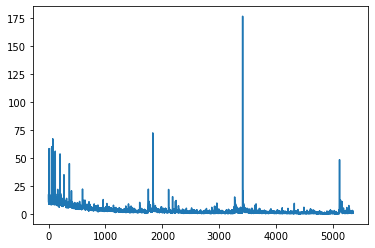

In [ ]:
n_epochs = 50

losses = {}
aux = {
    "safe_to_walk": 1,
    "roadway_width_cat": 1,
    "crosswalk": 1,
    "crosswalk_signal": 1,
    "traffic_light": 1,
    "car": 1,
    "scooter": 1,
    "bike": 1,
    "other_obstacles": 1,
    "no_obstacle_in_crosswalk": 1,
    "weather_cat": 1
}

seen = 0

model.train()
model = model.to(device)

for i in range(n_epochs):
    for j, (x, y) in enumerate(train_dl):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
#         print("output size", output.size())
        losses["safe_to_walk"] = safe_to_walk_loss_fn(output[:, 0], y[:, 0].view(-1).float())
        losses["roadway_width_cat"] = roadway_width_cat_loss_fn(output[:, 1:9], y[:, 1].long())
        losses["crosswalk"] = crosswalk_loss_fn(output[:, 9], y[:, 2].view(-1).float())
        losses["crosswalk_signal"] = crosswalk_signal_cat_loss_fn(output[:, 10:13], y[:, 3].long())
        losses["traffic_light"] = traffic_light_cat_loss_fn(output[:, 13:16], y[:, 4].long())
        losses["car"] = car_loss_fn(output[:, 16], y[:, 5].view(-1).float())
        losses["scooter"] = scooter_loss_fn(output[:, 17], y[:, 6].view(-1).float())
        losses["bike"] = bike_loss_fn(output[:, 18], y[:, 7].view(-1).float())
        losses["other_obstacles"] = other_obstacles_loss_fn(output[:, 19], y[:, 8].view(-1).float())
        losses["no_obstacle_in_crosswalk"] = no_obstacle_in_crosswalk_loss_fn(output[:, 20], y[:, 9].view(-1).float())
        losses["weather_cat"] = weather_cat_loss_fn(output[:, 21:24], y[:, 10].long())
        # 本日最高潮
        loss = (aux["safe_to_walk"] * losses["safe_to_walk"] 
                + aux["roadway_width_cat"] * losses["roadway_width_cat"] 
                + aux["crosswalk"] * losses["crosswalk"] 
                + aux["crosswalk_signal"] * losses["crosswalk_signal"] 
                + aux["traffic_light"] * losses["traffic_light"] 
                + aux["car"] * losses["car"] 
                + aux["scooter"] * losses["scooter"] 
                + aux["bike"] * losses["bike"] 
                + aux["other_obstacles"] * losses["other_obstacles"] 
                + aux["no_obstacle_in_crosswalk"] * losses["no_obstacle_in_crosswalk"] 
                + aux["weather_cat"] * losses["weather_cat"])
        loss_history.append(loss)
        # TODO: weights for losses 
        loss.backward()
        optimizer.step()
        seen = seen + x.size(0)
        print("epoch {:3d}  seen {:6d}  loss {:7.3f}".format(i, seen, loss.item()))
        learning_log.append({
            "epoch": i,
            "seen": seen,
            "loss": loss.item(),
        })
    # Save model after 5 epochs
    if (i + 1) % 10 == 0:
      torch.save(model, f'右濤/vgg16_all_epoch{i + 1}_256_3')
    # TODO: Validate after each epoch
df_learning = pd.DataFrame(learning_log)
df_learning

plt.figure()
plt.plot(loss_history)
plt.show()

## Validation

In [ ]:
val_outputs = []
val_labels = []

model.eval()
model = model.to(device)

for j, (x, y) in enumerate(val_dl):
  x = x.to(device)
  y = y.to(device)
  with torch.no_grad():
      t1 = time.time()
      output = model(x)
      val_outputs.append(output)
      val_labels.append(y)
      t2 = time.time()
      t_elapsed = t2 - t1
      print(j, "time elapsed: {:5.1f}".format(t_elapsed))

0 time elapsed:   0.0
1 time elapsed:   0.0
2 time elapsed:   0.0
3 time elapsed:   0.0
4 time elapsed:   0.0
5 time elapsed:   0.0
6 time elapsed:   0.0


In [ ]:
outputs_np = np.concatenate([o.data.cpu().numpy() for o in val_outputs])
outputs_np.shape

(57, 24)

In [ ]:
val_labels_np = np.concatenate([l.data.cpu().numpy() for l in val_labels])
val_labels_np.shape

(57, 11)

In [ ]:
result_val = {}

### safe_to_walk

In [ ]:
val_labels_np[:, 0]

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1])

In [ ]:
safe_to_walk_pred_val = np.where(outputs_np[:, 0] > 0, 1, 0)
safe_to_walk_pred_val

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1])

In [ ]:
safe_to_walk_cm_val = confusion_matrix(val_labels_np[:, 0], safe_to_walk_pred_val, normalize="true")
safe_to_walk_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.71428571, 0.28571429],
       [0.34482759, 0.65517241]])

In [ ]:
val_acc = np.sum(val_labels_np[:, 0] == safe_to_walk_pred_val) / safe_to_walk_pred_val.size
result_val['safe_to_walk'] = val_acc
val_acc

0.6842105263157895

Text(0, 0.5, 'ground truth')

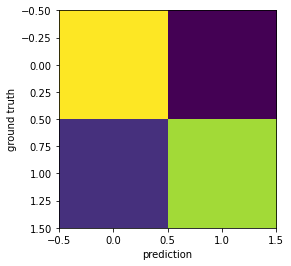

In [ ]:
fig = plt.figure()
plt.imshow(safe_to_walk_cm_val)
plt.xlabel("prediction")
plt.ylabel("ground truth")

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(safe_to_walk_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 0][i]) == int(safe_to_walk_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 0][i], safe_to_walk_pred_val[i]), color=color)

### roadway_width

In [ ]:
val_labels_np[:, 1]

array([4, 6, 1, 1, 4, 1, 7, 6, 2, 6, 1, 1, 1, 4, 1, 5, 2, 6, 6, 6, 1, 5,
       5, 6, 2, 3, 1, 3, 6, 4, 3, 1, 2, 5, 1, 2, 6, 1, 4, 3, 5, 1, 7, 6,
       5, 6, 4, 1, 2, 5, 2, 6, 6, 7, 6, 1, 2])

In [ ]:
# prediction
roadway_width_top_pred_val = np.argsort(-1 * outputs_np[:, 1:9], axis=1)
roadway_width_top_pred_val

array([[3, 1, 5, 2, 4, 6, 0, 7],
       [6, 2, 3, 1, 5, 0, 7, 4],
       [3, 0, 5, 1, 2, 6, 4, 7],
       [1, 3, 2, 4, 5, 0, 6, 7],
       [4, 3, 6, 2, 7, 5, 1, 0],
       [2, 1, 3, 5, 4, 6, 0, 7],
       [7, 4, 5, 6, 2, 1, 3, 0],
       [2, 6, 1, 3, 4, 5, 7, 0],
       [3, 1, 2, 4, 5, 6, 0, 7],
       [1, 3, 6, 5, 2, 4, 0, 7],
       [1, 3, 2, 0, 5, 6, 4, 7],
       [1, 2, 3, 4, 5, 6, 7, 0],
       [1, 3, 0, 5, 2, 6, 4, 7],
       [4, 5, 3, 2, 1, 6, 7, 0],
       [1, 2, 3, 5, 0, 4, 6, 7],
       [5, 3, 4, 2, 6, 1, 0, 7],
       [1, 2, 3, 5, 0, 4, 6, 7],
       [6, 3, 5, 4, 2, 1, 7, 0],
       [6, 2, 3, 5, 7, 4, 0, 1],
       [6, 3, 4, 2, 5, 7, 1, 0],
       [1, 3, 2, 0, 5, 4, 6, 7],
       [5, 6, 3, 4, 2, 0, 1, 7],
       [5, 3, 6, 2, 4, 0, 1, 7],
       [6, 3, 5, 7, 4, 2, 0, 1],
       [2, 3, 1, 6, 4, 7, 5, 0],
       [3, 4, 1, 2, 6, 5, 0, 7],
       [2, 3, 4, 5, 1, 6, 7, 0],
       [1, 2, 3, 0, 5, 7, 6, 4],
       [6, 3, 4, 2, 5, 7, 1, 0],
       [4, 3, 5, 2, 1, 6, 7, 0],
       [3,

In [ ]:
# top 1
roadway_width_pred_val = np.argmax(outputs_np[:, 1:9], axis=1)
roadway_width_pred_val

array([3, 6, 3, 1, 4, 2, 7, 2, 3, 1, 1, 1, 1, 4, 1, 5, 1, 6, 6, 6, 1, 5,
       5, 6, 2, 3, 2, 1, 6, 4, 3, 1, 2, 5, 1, 1, 6, 1, 4, 3, 5, 3, 7, 6,
       6, 6, 4, 1, 2, 2, 2, 6, 6, 7, 2, 3, 3])

In [ ]:
roadway_width_cm_val = confusion_matrix(val_labels_np[:, 1], roadway_width_pred_val, normalize="true")
roadway_width_cm_val

array([[0.66666667, 0.13333333, 0.2       , 0.        , 0.        ,
        0.        , 0.        ],
       [0.25      , 0.5       , 0.25      , 0.        , 0.        ,
        0.        , 0.        ],
       [0.25      , 0.        , 0.75      , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.16666667, 0.83333333, 0.        ,
        0.        , 0.        ],
       [0.        , 0.14285714, 0.        , 0.        , 0.71428571,
        0.14285714, 0.        ],
       [0.07142857, 0.14285714, 0.        , 0.        , 0.        ,
        0.78571429, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ]])

In [ ]:
val_acc = np.sum(val_labels_np[:, 1] == roadway_width_pred_val) / roadway_width_pred_val.size
result_val['roadway_width'] = val_acc
val_acc

0.7192982456140351

In [ ]:
# top 3
roadway_width_top3_pred_val_acc = np.sum(np.logical_or(val_labels_np[:, 1] == roadway_width_top_pred_val[:, 0], 
                                     val_labels_np[:, 1] == roadway_width_top_pred_val[:, 1],
                                     val_labels_np[:, 1] == roadway_width_top_pred_val[:, 2])) / roadway_width_pred_val.size
result_val['roadway_width_top3'] = roadway_width_top3_pred_val_acc
roadway_width_top3_pred_val_acc

0.8245614035087719

In [ ]:
# neighbor
roadway_width_neighbor_pred_val_acc = np.sum(np.abs(val_labels_np[:, 1] - roadway_width_pred_val) <= 1) / roadway_width_pred_val.size
result_val['roadway_width_neighbor'] = roadway_width_neighbor_pred_val_acc
roadway_width_neighbor_pred_val_acc

0.8596491228070176

Text(0, 0.5, 'ground truth')

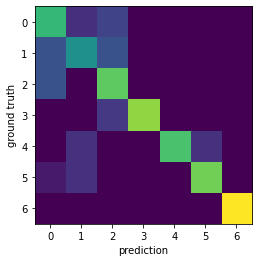

In [ ]:
fig = plt.figure()
plt.imshow(roadway_width_cm_val)
plt.xlabel("prediction")
plt.ylabel("ground truth")

Text(0.5, 0, 'ground truth')

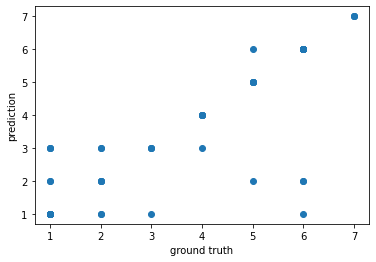

In [ ]:
plt.figure()
plt.scatter(val_labels_np[:, 1], roadway_width_pred_val)
plt.ylabel("prediction")
plt.xlabel("ground truth")

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(roadway_width_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 1][i]) == int(roadway_width_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 1][i] * 5, roadway_width_pred_val[i] * 5), color=color)

### crosswalk

In [ ]:
val_labels_np[:, 2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
crosswalk_pred_val = np.where(outputs_np[:, 9] > 0, 1, 0)
crosswalk_pred_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [ ]:
val_acc = np.sum(val_labels_np[:, 2] == crosswalk_pred_val) / crosswalk_pred_val.size
result_val['crosswalk'] = val_acc
val_acc

0.9649122807017544

In [ ]:
crosswalk_pred_cm_val = confusion_matrix(val_labels_np[:, 2], crosswalk_pred_val, normalize="true")
crosswalk_pred_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.        , 0.        ],
       [0.03508772, 0.96491228]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(crosswalk_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 2][i]) == int(crosswalk_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 2][i], crosswalk_pred_val[i]), color=color)

### crosswalk_signal

In [ ]:
val_labels_np[:, 3]

array([0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 1])

In [ ]:
crosswalk_signal_pred_val = np.argmax(outputs_np[:, 10:13], axis=1)
crosswalk_signal_pred_val

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0])

In [ ]:
val_acc = np.sum(val_labels_np[:, 3] == crosswalk_signal_pred_val) / crosswalk_signal_pred_val.size
result_val['crosswalk_signal'] = val_acc
val_acc

0.5789473684210527

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(crosswalk_signal_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 3][i]) == int(crosswalk_signal_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 3][i], crosswalk_signal_pred_val[i]), color=color)

### traffic_light

In [ ]:
val_labels_np[:, 4]

array([0, 1, 1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 1, 0, 2, 1,
       1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1,
       2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2])

In [ ]:
traffic_light_pred_val = np.argmax(outputs_np[:, 13:16], axis=1)
traffic_light_pred_val

array([2, 0, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2, 1,
       0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1,
       0, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2])

In [ ]:
val_acc = np.sum(val_labels_np[:, 4] == traffic_light_pred_val) / traffic_light_pred_val.size
result_val['traffic_light'] = val_acc
val_acc

0.7017543859649122

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(traffic_light_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 4][i]) == int(traffic_light_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 4][i], traffic_light_pred_val[i]), color=color)

### car

In [ ]:
val_labels_np[:, 5]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
car_pred_val = np.where(outputs_np[:, 16] > 0, 1, 0)
car_pred_val

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0])

In [ ]:
val_acc = np.sum(val_labels_np[:, 5] == car_pred_val) / car_pred_val.size
result_val['car'] = val_acc
val_acc

0.8771929824561403

In [ ]:
car_pred_cm_val = confusion_matrix(val_labels_np[:, 5], car_pred_val, normalize="true")
car_pred_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.89361702, 0.10638298],
       [0.2       , 0.8       ]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(car_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 5][i]) == int(car_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 5][i], car_pred_val[i]), color=color)

### scooter

In [ ]:
val_labels_np[:, 6]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
scooter_pred_val = np.where(outputs_np[:, 17] > 0, 1, 0)
scooter_pred_val

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
val_acc = np.sum(val_labels_np[:, 6] == scooter_pred_val) / scooter_pred_val.size
result_val['scooter'] = val_acc
val_acc

0.9824561403508771

In [ ]:
scooter_pred_cm_val = confusion_matrix(val_labels_np[:, 6], scooter_pred_val, normalize="true")
scooter_pred_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.98113208, 0.01886792],
       [0.        , 1.        ]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(scooter_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 6][i]) == int(scooter_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 6][i], scooter_pred_val[i]), color=color)

### bike

In [ ]:
val_labels_np[:, 7]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
bike_pred_val = np.where(outputs_np[:, 18] > 0, 1, 0)
bike_pred_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
val_acc = np.sum(val_labels_np[:, 7] == bike_pred_val) / bike_pred_val.size
result_val['bike'] = val_acc
val_acc

0.9824561403508771

In [ ]:
bike_pred_cm_val = confusion_matrix(val_labels_np[:, 7], bike_pred_val, normalize="true")
bike_pred_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[1. , 0. ],
       [0.5, 0.5]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(bike_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 7][i]) == int(bike_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 7][i], bike_pred_val[i]), color=color)

### other_obstacles

In [ ]:
val_labels_np[:, 8]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
other_obstacles_pred_val = np.where(outputs_np[:, 19] > 0, 1, 0)
other_obstacles_pred_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
val_acc = np.sum(val_labels_np[:, 8] == other_obstacles_pred_val) / other_obstacles_pred_val.size
result_val['other_obstacles'] = val_acc
val_acc

1.0

In [ ]:
other_obstacles_pred_cm_val = confusion_matrix(val_labels_np[:, 8], other_obstacles_pred_val, normalize="true")
other_obstacles_pred_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[1.]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(other_obstacles_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 8][i]) == int(other_obstacles_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 8][i], other_obstacles_pred_val[i]), color=color)

### no_obstacle_in_crosswalk

In [ ]:
val_labels_np[:, 9]

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [ ]:
no_obstacle_in_crosswalk_pred_val = np.where(outputs_np[:, 20] > 0, 1, 0)
no_obstacle_in_crosswalk_pred_val

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1])

In [ ]:
val_acc = np.sum(val_labels_np[:, 9] == no_obstacle_in_crosswalk_pred_val) / no_obstacle_in_crosswalk_pred_val.size
result_val['no_obstacle_in_crosswalk'] = val_acc
val_acc

0.8771929824561403

In [ ]:
no_obstacle_in_crosswalk_pred_cm_val = confusion_matrix(val_labels_np[:, 9], no_obstacle_in_crosswalk_pred_val, normalize="true")
no_obstacle_in_crosswalk_pred_cm_val
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.85714286, 0.14285714],
       [0.11627907, 0.88372093]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(no_obstacle_in_crosswalk_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 9][i]) == int(no_obstacle_in_crosswalk_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 9][i], no_obstacle_in_crosswalk_pred_val[i]), color=color)

### weather

In [ ]:
val_labels_np[:, 10]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
weather_pred_val = np.argmax(outputs_np[:, 21:24], axis=1)
weather_pred_val

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
val_acc = np.sum(val_labels_np[:, 10] == weather_pred_val) / weather_pred_val.size
result_val['weather'] = val_acc
val_acc

0.9473684210526315

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(weather_pred_val.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_labels_np[:, 10][i]) == int(weather_pred_val[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_labels_np[:, 10][i], weather_pred_val[i]), color=color)

### Result

In [ ]:
result_val

{'bike': 0.9824561403508771,
 'car': 0.8771929824561403,
 'crosswalk': 0.9649122807017544,
 'crosswalk_signal': 0.5789473684210527,
 'no_obstacle_in_crosswalk': 0.8771929824561403,
 'other_obstacles': 1.0,
 'roadway_width': 0.7192982456140351,
 'roadway_width_neighbor': 0.8596491228070176,
 'roadway_width_top3': 0.8245614035087719,
 'safe_to_walk': 0.6842105263157895,
 'scooter': 0.9824561403508771,
 'traffic_light': 0.7017543859649122,
 'weather': 0.9473684210526315}

{'bike': 0.9824561403508771,
 'car': 0.9298245614035088,
 'crosswalk': 0.9824561403508771,
 'crosswalk_signal': 0.5789473684210527,
 'no_obstacle_in_crosswalk': 0.9122807017543859,
 'other_obstacles': 1.0,
 'roadway_width': 0.7543859649122807,
 'safe_to_walk': 0.6842105263157895,
 'scooter': 0.9649122807017544,
 'traffic_light': 0.7192982456140351,
 'weather': 0.9473684210526315}

## Test

In [ ]:
test_outputs = []
test_labels = []

model.eval()
model = model.to(device)

for j, (x, y) in enumerate(test_dl):
  x = x.to(device)
  y = y.to(device)
  with torch.no_grad():
      t1 = time.time()
      output = model(x)
      test_outputs.append(output)
      test_labels.append(y)
      t2 = time.time()
      t_elapsed = t2 - t1
      print(j, "time elapsed: {:5.1f}".format(t_elapsed))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 time elapsed:   0.6
1 time elapsed:   0.0
2 time elapsed:   0.0
3 time elapsed:   0.0


KeyboardInterrupt: ignored

In [ ]:
outputs_np = np.concatenate([o.data.cpu().numpy() for o in test_outputs])
outputs_np.shape

(57, 24)

In [ ]:
test_labels_np = np.concatenate([l.data.cpu().numpy() for l in test_labels])
test_labels_np.shape

(57, 11)

In [ ]:
result_test = {}

### safe_to_walk

In [ ]:
test_labels_np[:, 0]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])

In [ ]:
safe_to_walk_pred_test = np.where(outputs_np[:, 0] > 0, 1, 0)
safe_to_walk_pred_test

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0])

In [ ]:
safe_to_walk_cm_test = confusion_matrix(test_labels_np[:, 0], safe_to_walk_pred_test, normalize="true")
safe_to_walk_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.73529412, 0.26470588],
       [0.34782609, 0.65217391]])

In [ ]:
test_acc = np.sum(test_labels_np[:, 0] == safe_to_walk_pred_test) / safe_to_walk_pred_test.size
result_test['safe_to_walk'] = test_acc
test_acc

0.7017543859649122

Text(0, 0.5, 'ground truth')

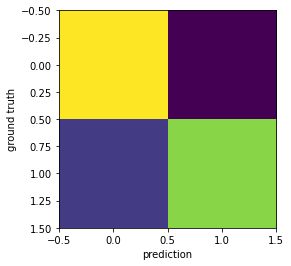

In [ ]:
fig = plt.figure()
plt.imshow(safe_to_walk_cm_test)
plt.xlabel("prediction")
plt.ylabel("ground truth")

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(safe_to_walk_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 0][i]) == int(safe_to_walk_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 0][i], safe_to_walk_pred_test[i]), color=color)

### roadway_width

In [ ]:
test_labels_np[:, 1]

array([5, 6, 5, 7, 2, 6, 3, 2, 6, 0, 2, 1, 2, 6, 6, 3, 2, 3, 5, 3, 2, 2,
       3, 3, 4, 6, 1, 3, 5, 3, 5, 2, 6, 2, 5, 6, 2, 3, 5, 4, 3, 4, 6, 6,
       2, 3, 3, 4, 4, 6, 1, 5, 2, 5, 4, 7, 6])

In [ ]:
# prediction
roadway_width_top_pred_test = np.argsort(-1 * outputs_np[:, 1:9], axis=1)
roadway_width_top_pred_test

array([[3, 5, 6, 1, 4, 2, 0, 7],
       [6, 5, 3, 4, 2, 1, 0, 7],
       [5, 6, 4, 3, 1, 0, 2, 7],
       [7, 5, 6, 3, 1, 2, 0, 4],
       [1, 3, 6, 2, 0, 5, 7, 4],
       [6, 3, 4, 2, 5, 7, 1, 0],
       [3, 4, 2, 1, 6, 5, 0, 7],
       [5, 4, 3, 2, 1, 6, 7, 0],
       [6, 4, 3, 5, 7, 2, 1, 0],
       [2, 1, 3, 0, 5, 6, 4, 7],
       [2, 1, 3, 5, 4, 6, 0, 7],
       [1, 3, 2, 5, 0, 4, 6, 7],
       [2, 3, 6, 1, 7, 0, 5, 4],
       [5, 3, 6, 2, 1, 4, 7, 0],
       [6, 5, 4, 2, 3, 7, 1, 0],
       [3, 1, 4, 2, 6, 5, 0, 7],
       [2, 3, 1, 6, 5, 4, 0, 7],
       [3, 6, 4, 2, 5, 1, 0, 7],
       [3, 2, 5, 1, 0, 6, 4, 7],
       [3, 1, 4, 2, 5, 6, 7, 0],
       [2, 1, 3, 6, 0, 5, 4, 7],
       [2, 1, 3, 0, 5, 6, 4, 7],
       [4, 5, 3, 1, 2, 7, 0, 6],
       [3, 1, 2, 5, 4, 6, 0, 7],
       [4, 2, 3, 5, 1, 7, 6, 0],
       [6, 3, 2, 5, 4, 7, 1, 0],
       [1, 3, 5, 2, 0, 6, 4, 7],
       [3, 1, 5, 2, 0, 6, 4, 7],
       [5, 6, 4, 3, 2, 1, 0, 7],
       [3, 6, 4, 2, 5, 1, 0, 7],
       [5,

In [ ]:
# top 1
roadway_width_pred_test = np.argmax(outputs_np[:, 1:9], axis=1)
roadway_width_pred_test

array([3, 6, 5, 7, 1, 6, 3, 5, 6, 2, 2, 1, 2, 5, 6, 3, 2, 3, 3, 3, 2, 2,
       4, 3, 4, 6, 1, 3, 5, 3, 5, 2, 2, 2, 5, 4, 2, 3, 5, 1, 3, 1, 6, 3,
       2, 3, 3, 4, 5, 6, 1, 1, 2, 5, 1, 4, 6])

In [ ]:
roadway_width_cm = confusion_matrix(test_labels_np[:, 1], roadway_width_pred_test, normalize="true")
roadway_width_cm

array([[0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.08333333, 0.83333333, 0.        , 0.        ,
        0.08333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.91666667, 0.08333333,
        0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        , 0.33333333,
        0.16666667, 0.        , 0.        ],
       [0.        , 0.11111111, 0.        , 0.22222222, 0.        ,
        0.66666667, 0.        , 0.        ],
       [0.        , 0.        , 0.08333333, 0.08333333, 0.08333333,
        0.08333333, 0.66666667, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.        , 0.        , 0.5       ]])

In [ ]:
# top 1
test_acc = np.sum(test_labels_np[:, 1] == roadway_width_pred_test) / roadway_width_pred_test.size
result_test['roadway_width'] = test_acc
test_acc

0.7192982456140351

In [ ]:
# top 3
roadway_width_top3_pred_test_acc = np.sum(np.logical_or(test_labels_np[:, 1] == roadway_width_top_pred_test[:, 0], 
                                     test_labels_np[:, 1] == roadway_width_top_pred_test[:, 1],
                                     test_labels_np[:, 1] == roadway_width_top_pred_test[:, 2])) / roadway_width_pred_test.size
result_test['roadway_width_top3'] = roadway_width_top3_pred_test_acc
roadway_width_top3_pred_test_acc

0.7719298245614035

In [ ]:
# neighbor
roadway_width_neighbor_pred_test_acc = np.sum(np.abs(test_labels_np[:, 1] - roadway_width_pred_test) <= 1) / roadway_width_pred_test.size
result_test['roadway_width_neighbor'] = roadway_width_neighbor_pred_test_acc
roadway_width_neighbor_pred_test_acc

0.7894736842105263

Text(0, 0.5, 'ground truth')

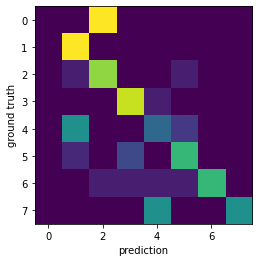

In [ ]:
fig = plt.figure()
plt.imshow(roadway_width_cm)
plt.xlabel("prediction")
plt.ylabel("ground truth")

Text(0.5, 0, 'ground truth')

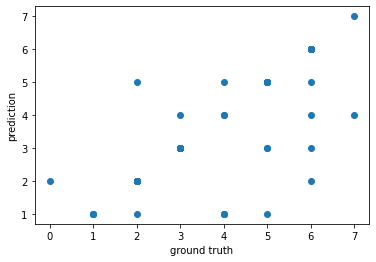

In [ ]:
plt.figure()
plt.scatter(test_labels_np[:, 1], roadway_width_pred_test)
plt.ylabel("prediction")
plt.xlabel("ground truth")

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(roadway_width_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 1][i]) == int(roadway_width_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 1][i] * 5, roadway_width_pred_test[i] * 5), color=color)

### crosswalk

In [ ]:
test_labels_np[:, 2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
crosswalk_pred_test = np.where(outputs_np[:, 9] > 0, 1, 0)
crosswalk_pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_acc = np.sum(test_labels_np[:, 2] == crosswalk_pred_test) / crosswalk_pred_test.size
result_test['crosswalk'] = test_acc
test_acc

0.9298245614035088

In [ ]:
crosswalk_pred_cm_test = confusion_matrix(test_labels_np[:, 2], crosswalk_pred_test, normalize="true")
crosswalk_pred_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.        , 0.        ],
       [0.07017544, 0.92982456]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(crosswalk_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 2][i]) == int(crosswalk_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 2][i], crosswalk_pred_test[i]), color=color)

### crosswalk_signal

In [ ]:
test_labels_np[:, 3]

array([0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1])

In [ ]:
crosswalk_signal_pred_test = np.argmax(outputs_np[:, 10:13], axis=1)
crosswalk_signal_pred_test

array([0, 0, 1, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
test_acc = np.sum(test_labels_np[:, 3] == crosswalk_signal_pred_test) / crosswalk_signal_pred_test.size
result_test['crosswalk_signal'] = test_acc
test_acc

0.631578947368421

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(crosswalk_signal_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 3][i]) == int(crosswalk_signal_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 3][i], crosswalk_signal_pred_test[i]), color=color)

### traffic_light

In [ ]:
test_labels_np[:, 4]

array([0, 0, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 0, 2,
       2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 0, 1,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1])

In [ ]:
traffic_light_pred_test = np.argmax(outputs_np[:, 13:16], axis=1)
traffic_light_pred_test

array([0, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1,
       1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 0, 2, 1, 2, 2, 1, 2, 1])

In [ ]:
test_acc = np.sum(test_labels_np[:, 4] == traffic_light_pred_test) / traffic_light_pred_test.size
result_test['traffic_light'] = test_acc
test_acc

0.5614035087719298

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(traffic_light_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 4][i]) == int(traffic_light_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 4][i], traffic_light_pred_test[i]), color=color)

### car

In [ ]:
test_labels_np[:, 5]

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
car_pred_test = np.where(outputs_np[:, 16] > 0, 1, 0)
car_pred_test

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
test_acc = np.sum(test_labels_np[:, 5] == car_pred_test) / car_pred_test.size
result_test['car'] = test_acc
test_acc

0.8771929824561403

In [ ]:
car_pred_cm_test = confusion_matrix(test_labels_np[:, 5], car_pred_test, normalize="true")
car_pred_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.84210526, 0.15789474],
       [0.05263158, 0.94736842]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(car_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 5][i]) == int(car_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 5][i], car_pred_test[i]), color=color)

### scooter

In [ ]:
test_labels_np[:, 6]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
scooter_pred_test = np.where(outputs_np[:, 17] > 0, 1, 0)
scooter_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_acc = np.sum(test_labels_np[:, 6] == scooter_pred_test) / scooter_pred_test.size
result_test['scooter'] = test_acc
test_acc

0.9298245614035088

In [ ]:
scooter_pred_cm_test = confusion_matrix(test_labels_np[:, 6], scooter_pred_test, normalize="true")
scooter_pred_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[1., 0.],
       [1., 0.]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(scooter_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 6][i]) == int(scooter_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 6][i], scooter_pred_test[i]), color=color)

### bike

In [ ]:
test_labels_np[:, 7]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
bike_pred_test = np.where(outputs_np[:, 18] > 0, 1, 0)
bike_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_acc = np.sum(test_labels_np[:, 7] == bike_pred_test) / bike_pred_test.size
result_test['bike'] = test_acc
test_acc

0.9298245614035088

In [ ]:
bike_pred_cm_test = confusion_matrix(test_labels_np[:, 7], bike_pred_test, normalize="true")
bike_pred_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.98113208, 0.01886792],
       [0.75      , 0.25      ]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(bike_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 7][i]) == int(bike_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 7][i], bike_pred_test[i]), color=color)

### other_obstacles

In [ ]:
test_labels_np[:, 8]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
other_obstacles_pred_test = np.where(outputs_np[:, 19] > 0, 1, 0)
other_obstacles_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_acc = np.sum(test_labels_np[:, 8] == other_obstacles_pred_test) / other_obstacles_pred_test.size
result_test['other_obstacles'] = test_acc
test_acc

0.9824561403508771

In [ ]:
other_obstacles_pred_cm_test = confusion_matrix(test_labels_np[:, 8], other_obstacles_pred_test, normalize="true")
other_obstacles_pred_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[1., 0.],
       [1., 0.]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(other_obstacles_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 8][i]) == int(other_obstacles_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 8][i], other_obstacles_pred_test[i]), color=color)

### no_obstacle_in_crosswalk

In [ ]:
test_labels_np[:, 9]

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0])

In [ ]:
no_obstacle_in_crosswalk_pred_test = np.where(outputs_np[:, 20] > 0, 1, 0)
no_obstacle_in_crosswalk_pred_test

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

In [ ]:
test_acc = np.sum(test_labels_np[:, 9] == no_obstacle_in_crosswalk_pred_test) / no_obstacle_in_crosswalk_pred_test.size
result_test['no_obstacle_in_crosswalk'] = test_acc
test_acc

0.8596491228070176

In [ ]:
no_obstacle_in_crosswalk_pred_cm_test = confusion_matrix(test_labels_np[:, 9], no_obstacle_in_crosswalk_pred_test, normalize="true")
no_obstacle_in_crosswalk_pred_cm_test
# (0, 0): the ratio of prdict == 0 in all label == 0  
# (0, 1): the ratio of prdict == 1 in all label == 0
# (1, 0): the ratio of prdict == 0 in all label == 1
# (1, 1): the ratio of prdict == 1 in all label == 1

array([[0.86956522, 0.13043478],
       [0.14705882, 0.85294118]])

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(no_obstacle_in_crosswalk_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 9][i]) == int(no_obstacle_in_crosswalk_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 9][i], no_obstacle_in_crosswalk_pred_test[i]), color=color)

### weather

In [ ]:
test_labels_np[:, 10]

array([1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
weather_pred_test = np.argmax(outputs_np[:, 21:24], axis=1)
weather_pred_test

array([0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [ ]:
test_acc = np.sum(test_labels_np[:, 10] == weather_pred_test) / weather_pred_test.size
result_test['weather'] = test_acc
test_acc

0.9298245614035088

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(weather_pred_test.size):
    plt.subplot(12, 5, i + 1)
    plt.axis("off")
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_labels_np[:, 10][i]) == int(weather_pred_test[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_labels_np[:, 10][i], weather_pred_test[i]), color=color)

### Result

In [ ]:
result_test

{'bike': 0.9298245614035088,
 'car': 0.8771929824561403,
 'crosswalk': 0.9298245614035088,
 'crosswalk_signal': 0.631578947368421,
 'no_obstacle_in_crosswalk': 0.8596491228070176,
 'other_obstacles': 0.9824561403508771,
 'roadway_width': 0.7192982456140351,
 'roadway_width_neighbor': 0.7894736842105263,
 'roadway_width_top3': 0.7719298245614035,
 'safe_to_walk': 0.7017543859649122,
 'scooter': 0.9298245614035088,
 'traffic_light': 0.5614035087719298,
 'weather': 0.9298245614035088}

{'bike': 0.9473684210526315,
 'car': 0.8947368421052632,
 'crosswalk': 0.9473684210526315,
 'crosswalk_signal': 0.631578947368421,
 'no_obstacle_in_crosswalk': 0.8771929824561403,
 'other_obstacles': 0.9824561403508771,
 'roadway_width': 0.5614035087719298,
 'safe_to_walk': 0.6666666666666666,
 'scooter': 0.9473684210526315,
 'traffic_light': 0.5789473684210527,
 'weather': 0.9473684210526315}

## Test_Video

In [ ]:
test_outputs = []
test_labels = []

model.eval()
model = model.to(device)

for j, (x, y) in enumerate(test_dl):
  x = x.to(device)
  y = y.to(device)
  with torch.no_grad():
      t1 = time.time()
      output = model(x)
      test_outputs.append(output)
      test_labels.append(y)
      t2 = time.time()
      t_elapsed = t2 - t1
      print(j, "time elapsed: {:5.1f}".format(t_elapsed))

0 time elapsed:   0.0
1 time elapsed:   0.0
2 time elapsed:   0.0
3 time elapsed:   0.0
4 time elapsed:   0.0
5 time elapsed:   0.0
6 time elapsed:   0.0
7 time elapsed:   0.0
8 time elapsed:   0.0
9 time elapsed:   0.0
10 time elapsed:   0.0
11 time elapsed:   0.0


In [ ]:
outputs_np = np.concatenate([o.data.cpu().numpy() for o in test_outputs])
outputs_np.shape

(104, 24)

In [ ]:
# test_labels_np = np.concatenate([l.data.cpu().numpy() for l in test_labels])
# test_labels_np.shape

In [ ]:
result_test = {}

### safe_to_walk

In [ ]:
safe_to_walk_pred_test = 1/(1 + np.exp(-outputs_np[:,0]))
safe_to_walk_pred_test

array([7.00328615e-04, 6.00279658e-04, 2.99737207e-04, 6.06630463e-04,
       4.82626114e-04, 2.94568454e-04, 8.37281870e-04, 5.98684535e-04,
       2.42366150e-04, 5.84518712e-04, 3.14775709e-04, 5.42913098e-04,
       2.38912689e-04, 1.74727084e-05, 1.54746631e-05, 7.57095040e-06,
       2.39622113e-05, 1.96728884e-04, 4.90073115e-04, 4.64007317e-04,
       2.82220729e-03, 3.97128565e-03, 7.87284411e-03, 6.32508949e-04,
       2.56714295e-04, 8.67980125e-04, 4.40885866e-04, 3.50565067e-04,
       8.77030689e-05, 1.72371263e-04, 4.06597916e-04, 5.55296289e-03,
       1.91369560e-03, 1.26673467e-03, 1.13408896e-03, 4.86844860e-04,
       4.94906737e-04, 1.29626380e-04, 1.20235607e-04, 3.06666421e-04,
       1.04250922e-03, 3.36595322e-03, 2.76698801e-03, 4.04553401e-04,
       3.63204337e-04, 3.10992473e-04, 2.23857554e-04, 1.85398734e-04,
       1.00752135e-04, 1.63930003e-04, 9.60675970e-05, 9.68165477e-06,
       7.17984312e-06, 2.26107477e-05, 1.58643052e-05, 2.49096811e-05,
      

In [ ]:
df['safe_to_walk'] = safe_to_walk_pred_test

In [ ]:
df

,path,filename,new_filename,subset,safe_to_walk,roadway_width,crosswalk,crosswalk_signal,traffic_light,car,scooter,bike,other_obstacles,no_obstacle_in_crosswalk,weather
0,V_pic_3/3_0001.png,3_0001.png,3_0001.jpg,test,0.000700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V_pic_3/3_0002.png,3_0002.png,3_0002.jpg,test,0.000600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V_pic_3/3_0003.png,3_0003.png,3_0003.jpg,test,0.000300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V_pic_3/3_0004.png,3_0004.png,3_0004.jpg,test,0.000607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V_pic_3/3_0005.png,3_0005.png,3_0005.jpg,test,0.000483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,V_pic_3/3_0100.png,3_0100.png,3_0100.jpg,test,0.138335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,V_pic_3/3_0101.png,3_0101.png,3_0101.jpg,test,0.060546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,V_pic_3/3_0102.png,3_0102.png,3_0102.jpg,test,0.046284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,V_pic_3/3_0103.png,3_0103.png,3_0103.jpg,test,0.016709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### roadway_width

In [ ]:
# # prediction
# roadway_width_top_pred_test = np.argsort(-1 * outputs_np[:, 1:9], axis=1)
# roadway_width_top_pred_test

In [ ]:
# top 1
roadway_width_pred_test = np.argmax(outputs_np[:, 1:9], axis=1) * 5
roadway_width_pred_test

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15])

In [ ]:
df['roadway_width'] = roadway_width_pred_test

In [ ]:
df

,path,filename,new_filename,subset,safe_to_walk,roadway_width,crosswalk,crosswalk_signal,traffic_light,car,scooter,bike,other_obstacles,no_obstacle_in_crosswalk,weather
0,V_pic_3/3_0001.png,3_0001.png,3_0001.jpg,test,0.000700,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V_pic_3/3_0002.png,3_0002.png,3_0002.jpg,test,0.000600,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V_pic_3/3_0003.png,3_0003.png,3_0003.jpg,test,0.000300,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V_pic_3/3_0004.png,3_0004.png,3_0004.jpg,test,0.000607,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V_pic_3/3_0005.png,3_0005.png,3_0005.jpg,test,0.000483,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,V_pic_3/3_0100.png,3_0100.png,3_0100.jpg,test,0.138335,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,V_pic_3/3_0101.png,3_0101.png,3_0101.jpg,test,0.060546,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,V_pic_3/3_0102.png,3_0102.png,3_0102.jpg,test,0.046284,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,V_pic_3/3_0103.png,3_0103.png,3_0103.jpg,test,0.016709,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### crosswalk

In [ ]:
crosswalk_pred_test = 1/(1 + np.exp(-outputs_np[:, 9]))
crosswalk_pred_test

array([0.8950645 , 0.7233504 , 0.9314765 , 0.8316621 , 0.7621934 ,
       0.8420912 , 0.9415465 , 0.78222394, 0.2733352 , 0.5538773 ,
       0.95794386, 0.97569376, 0.97145474, 0.99748504, 0.9978422 ,
       0.9687449 , 0.9749903 , 0.9474251 , 0.798102  , 0.48303884,
       0.99008626, 0.9893267 , 0.9950631 , 0.98697346, 0.88453037,
       0.99660516, 0.7374408 , 0.518787  , 0.3288918 , 0.21866061,
       0.46258372, 0.9637192 , 0.77840054, 0.6990259 , 0.94729435,
       0.97990936, 0.7512944 , 0.5111483 , 0.08743069, 0.14833361,
       0.56280154, 0.94896805, 0.9885861 , 0.8751488 , 0.6711063 ,
       0.66682535, 0.28964132, 0.2841864 , 0.16048488, 0.37185222,
       0.34900352, 0.07122734, 0.12292232, 0.0460877 , 0.02818185,
       0.028432  , 0.08165453, 0.08070022, 0.06067529, 0.16944031,
       0.75621414, 0.77897   , 0.9366184 , 0.8556556 , 0.9720733 ,
       0.7824134 , 0.97421885, 0.92799747, 0.73400927, 0.99794585,
       0.9943606 , 0.97835743, 0.9963558 , 0.96806866, 0.98838

In [ ]:
df['crosswalk'] = crosswalk_pred_test

### crosswalk_signal

In [ ]:
crosswalk_signal_pred_test = np.argmax(outputs_np[:, 10:13], axis=1)
crosswalk_signal_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
df['crosswalk_signal'] = crosswalk_signal_pred_test

### traffic_light

In [ ]:
traffic_light_pred_test = np.argmax(outputs_np[:, 13:16], axis=1)
traffic_light_pred_test

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
df['traffic_light'] = traffic_light_pred_test

### car

In [ ]:
car_pred_test = 1/(1 + np.exp(-outputs_np[:, 16]))
car_pred_test

array([0.9999049 , 0.99984765, 0.9999304 , 0.99989426, 0.99986875,
       0.9999467 , 0.9998258 , 0.9998926 , 0.9999907 , 0.99995077,
       0.9999901 , 0.9999883 , 0.9999987 , 0.9999999 , 0.9999999 ,
       1.        , 0.9999999 , 0.9999982 , 0.99998796, 0.999984  ,
       0.9992187 , 0.9986879 , 0.99869764, 0.9997335 , 0.9997291 ,
       0.9998565 , 0.99970335, 0.9998317 , 0.99976534, 0.99981374,
       0.9993641 , 0.9975249 , 0.99940205, 0.9995141 , 0.9999212 ,
       0.99997854, 0.9998952 , 0.9999908 , 0.99999464, 0.99997306,
       0.99988365, 0.99977654, 0.9999068 , 0.99999034, 0.9999924 ,
       0.999997  , 0.9999833 , 0.99999225, 0.9999937 , 0.9999907 ,
       0.999995  , 0.99997544, 0.99996424, 0.9999682 , 0.9998535 ,
       0.9997904 , 0.99978656, 0.9999685 , 0.99997103, 0.9999924 ,
       0.99984324, 0.99959666, 0.9993907 , 0.9998331 , 0.9995491 ,
       0.99988997, 0.9997677 , 0.9998971 , 0.9999795 , 0.9996377 ,
       0.9997203 , 0.99992204, 0.9991227 , 0.99957544, 0.99525

In [ ]:
df['car'] = car_pred_test

### scooter

In [ ]:
scooter_pred_test = 1/(1 + np.exp(-outputs_np[:, 17]))
scooter_pred_test

array([4.32221452e-03, 8.11055675e-03, 5.90642495e-03, 5.56469522e-03,
       7.22205546e-03, 4.16112738e-03, 4.42315266e-03, 5.97478822e-03,
       1.31130626e-03, 4.27654153e-03, 1.35245197e-03, 5.40309935e-04,
       6.99151569e-05, 1.85181590e-04, 6.39821665e-05, 4.05606406e-05,
       2.65473664e-05, 1.10908601e-04, 5.13500301e-04, 1.60105410e-03,
       1.03532746e-02, 1.43246036e-02, 5.83913876e-03, 3.77757698e-02,
       9.07779485e-02, 6.47048745e-03, 8.79100561e-02, 3.88270915e-02,
       3.30995560e-01, 1.41606346e-01, 1.74224824e-01, 6.76103607e-02,
       5.67225926e-02, 1.53929755e-01, 3.59790795e-03, 8.76361562e-04,
       1.74428597e-02, 6.18298817e-03, 2.80528283e-03, 1.07902065e-02,
       1.79177653e-02, 3.37815308e-03, 6.14937441e-03, 4.27824119e-03,
       2.61748419e-03, 1.24573766e-03, 2.89498246e-03, 1.09264476e-03,
       2.18273047e-02, 2.23679300e-02, 2.28561517e-02, 6.76195323e-01,
       8.57015848e-01, 6.94806635e-01, 9.69346583e-01, 9.35248315e-01,
      

In [ ]:
df['scooter'] = scooter_pred_test

### bike

In [ ]:
bike_pred_test = 1/(1 + np.exp(-outputs_np[:, 18]))
bike_pred_test

array([1.40328948e-05, 2.92639179e-05, 8.11192695e-06, 1.25088163e-05,
       1.60344753e-05, 9.51076254e-06, 1.50209798e-05, 1.52062457e-05,
       7.24270603e-06, 1.97396057e-05, 3.98267548e-06, 4.73567025e-06,
       1.18640025e-06, 1.04629947e-07, 1.15651552e-07, 1.49449718e-07,
       1.00533398e-07, 3.95635112e-07, 2.45909837e-06, 3.04604646e-06,
       5.98149245e-06, 1.37393699e-05, 7.92387891e-06, 6.66221968e-06,
       7.04340437e-06, 4.64738423e-06, 3.54645854e-05, 1.56994447e-05,
       3.52625393e-05, 5.61138004e-05, 7.84270451e-05, 5.17527165e-04,
       3.01777036e-04, 6.55262498e-04, 8.70141521e-05, 2.53645339e-05,
       1.59043644e-04, 3.95407296e-05, 2.28184435e-05, 1.62781100e-04,
       3.27089976e-04, 9.68489796e-04, 5.07805962e-04, 9.45884531e-05,
       2.64744049e-05, 1.41236815e-05, 1.00198253e-04, 3.17477643e-05,
       4.38322786e-05, 4.40661039e-04, 2.65908369e-04, 1.34113012e-04,
       1.50462984e-05, 4.81371935e-05, 1.49172076e-04, 2.65011418e-04,
      

In [ ]:
df['bike'] = bike_pred_test

### other_obstacles

In [ ]:
other_obstacles_pred_test = 1/(1 + np.exp(-outputs_np[:, 19]))
other_obstacles_pred_test

array([6.55791013e-16, 5.65974498e-16, 1.37954006e-16, 4.13185848e-16,
       3.45973254e-16, 1.31622078e-16, 1.31710473e-16, 1.85446283e-16,
       1.37876145e-16, 6.27225441e-15, 2.41863879e-16, 1.47920646e-16,
       1.31789310e-17, 1.87182313e-19, 6.71361693e-20, 3.59347395e-19,
       4.17803596e-20, 3.57684348e-19, 1.27840838e-17, 8.16808032e-17,
       1.47472155e-16, 5.60251996e-16, 2.86697227e-16, 1.08523251e-16,
       1.05858982e-16, 5.35336701e-17, 1.00350428e-15, 1.20051060e-15,
       8.61633042e-16, 4.80683024e-15, 3.79903594e-15, 2.06703131e-13,
       1.20924687e-13, 1.63176742e-12, 7.97236473e-15, 9.31068357e-16,
       3.51388623e-13, 1.86005504e-14, 9.07459007e-16, 1.01270336e-14,
       5.19613615e-14, 4.95922849e-14, 7.42805628e-15, 3.18676903e-16,
       2.17916471e-16, 2.79220652e-16, 2.98143104e-15, 1.99071761e-16,
       1.26766713e-16, 2.38477732e-16, 1.56886926e-16, 1.03266035e-16,
       8.24209587e-19, 7.87106359e-17, 2.23993204e-16, 1.97530942e-15,
      

In [ ]:
df['other_obstacles'] = other_obstacles_pred_test

### no_obstacle_in_crosswalk

In [ ]:
no_obstacle_in_crosswalk_pred_test = 1/(1 + np.exp(-outputs_np[:, 20]))
no_obstacle_in_crosswalk_pred_test

array([1.51686225e-04, 1.28462460e-04, 1.01067177e-04, 1.36951057e-04,
       1.21582103e-04, 8.61974549e-05, 2.79710279e-04, 9.16923454e-05,
       1.15582652e-05, 8.55365070e-05, 3.44510991e-05, 6.63783430e-05,
       9.04615990e-06, 1.20868708e-06, 6.72653982e-07, 2.66293569e-07,
       4.40682328e-07, 5.45612738e-06, 2.05813376e-05, 3.85563580e-05,
       1.14440243e-03, 1.63566740e-03, 2.15407694e-03, 4.23573074e-04,
       1.63339588e-04, 3.31522868e-04, 2.10440150e-04, 9.86171362e-05,
       5.08443336e-05, 5.79893203e-05, 1.20110257e-04, 1.25176681e-03,
       4.22957994e-04, 3.23758577e-04, 1.60109208e-04, 5.92018259e-05,
       1.88827340e-04, 2.18482455e-05, 1.01291225e-05, 3.15628677e-05,
       1.23771926e-04, 5.00185182e-04, 2.49919976e-04, 1.95127068e-05,
       1.21635585e-05, 8.98436247e-06, 2.12691393e-05, 9.55482756e-06,
       4.46732611e-06, 6.60493652e-06, 3.86312831e-06, 1.61292974e-06,
       7.62354773e-07, 1.76614969e-06, 1.83812210e-06, 5.28891178e-06,
      

In [ ]:
df['no_obstacle_in_crosswalk'] = no_obstacle_in_crosswalk_pred_test

### weather

In [ ]:
weather_pred_test = np.argmax(outputs_np[:, 21:24], axis=1)
weather_pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
df['weather'] = weather_pred_test

### Result

In [ ]:
df

,path,filename,new_filename,subset,safe_to_walk,roadway_width,crosswalk,crosswalk_signal,traffic_light,car,scooter,bike,other_obstacles,no_obstacle_in_crosswalk,weather
0,V_pic_3/3_0001.png,3_0001.png,3_0001.jpg,test,0.000700,15,0.895064,0,2,0.999905,0.004322,0.000014,6.557910e-16,0.000152,1
1,V_pic_3/3_0002.png,3_0002.png,3_0002.jpg,test,0.000600,15,0.723350,0,2,0.999848,0.008111,0.000029,5.659745e-16,0.000128,1
2,V_pic_3/3_0003.png,3_0003.png,3_0003.jpg,test,0.000300,15,0.931476,0,2,0.999930,0.005906,0.000008,1.379540e-16,0.000101,1
3,V_pic_3/3_0004.png,3_0004.png,3_0004.jpg,test,0.000607,15,0.831662,0,0,0.999894,0.005565,0.000013,4.131858e-16,0.000137,1
4,V_pic_3/3_0005.png,3_0005.png,3_0005.jpg,test,0.000483,15,0.762193,0,2,0.999869,0.007222,0.000016,3.459733e-16,0.000122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,V_pic_3/3_0100.png,3_0100.png,3_0100.jpg,test,0.138335,15,0.999367,1,2,0.924231,0.036140,0.000067,2.419359e-16,0.023605,1
100,V_pic_3/3_0101.png,3_0101.png,3_0101.jpg,test,0.060546,15,0.998415,1,2,0.975212,0.021608,0.000073,2.529004e-16,0.013104,1
101,V_pic_3/3_0102.png,3_0102.png,3_0102.jpg,test,0.046284,15,0.998189,1,2,0.977000,0.030086,0.000190,5.253372e-16,0.010691,1
102,V_pic_3/3_0103.png,3_0103.png,3_0103.jpg,test,0.016709,15,0.993662,1,2,0.987761,0.092670,0.000256,1.244672e-15,0.003295,1


In [ ]:
df.to_csv('video_data_info_3.csv')

## Save & Load

### Save

In [ ]:
torch.save(model, '右濤/vgg16_all_epoch50_256_3')

### Load

In [ ]:
model = torch.load('右濤/vgg16_all_epoch50_256_3')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1